Environment: `py39_torch271`

In [1]:
import os
import random
from copy import deepcopy

from typing import Optional
from dataclasses import dataclass, asdict
from pathlib import Path
from datetime import datetime

import torch
import numpy as np
import pandas as pd
from dacite import from_dict
from sklearn.model_selection import train_test_split

from pyrutils.torch.train_utils import train, save_checkpoint
from pyrutils.torch.multi_task import MultiTaskLossLearner
from vhoi.data_loading import (
    input_size_from_data_loader, 
    select_model_data_feeder, 
    select_model_data_fetcher,
)
from vhoi.data_loading_custom import (
    create_data,
    create_data_loader
)
from vhoi.losses_custom_v2 import (
    select_loss, 
    decide_num_main_losses, 
    select_loss_types, 
    select_loss_learning_mask,
)
from vhoi.models import load_model_weights
from vhoi.models_custom_v2 import TGGCN

seed = 42
random.seed(seed)   # Python的随机性
os.environ['PYTHONHASHSEED'] = str(seed)    # 设置Python哈希种子，为了禁止hash随机化，使得实验可复现
np.random.seed(seed)   # numpy的随机性
torch.manual_seed(seed)   # torch的CPU随机性，为CPU设置随机种子
torch.cuda.manual_seed(seed)   # torch的GPU随机性，为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.   torch的GPU随机性，为所有GPU设置随机种子
torch.backends.cudnn.benchmark = False   # if benchmark=True, deterministic will be False
torch.backends.cudnn.deterministic = True   # 选择确定性算法

In [ ]:
class DictMixin:
    def get(self, key, default_value=None):
        return getattr(self, key, default_value)

    def as_dict(self):
        return asdict(self)
    
@dataclass
class Resources(DictMixin):
    use_gpu: bool
    num_threads: int

@dataclass
class ModelMetadata(DictMixin):
    model_name: str
    input_type: str

@dataclass
class ModelParameters(DictMixin):
    add_segment_length: int
    add_time_position: int
    time_position_strategy: str
    positional_encoding_style: str
    attention_style: str
    bias: bool
    cat_level_states: int
    discrete_networks_num_layers: int
    discrete_optimization_strategy: str
    filter_discrete_updates: bool
    gcn_node: int
    hidden_size: int
    message_humans_to_human: bool
    message_human_to_objects: bool
    message_objects_to_human: bool
    message_objects_to_object: bool
    message_geometry_to_objects: bool
    message_geometry_to_human: bool
    message_segment: bool
    message_type: str
    message_granularity: str
    message_aggregation: str
    object_segment_update_strategy: str
    share_level_mlps: int
    update_segment_threshold: float

@dataclass
class ModelOptimization(DictMixin):
    batch_size: int
    clip_gradient_at: float
    epochs: int
    learning_rate: float
    val_fraction: float

@dataclass
class BudgetLoss(DictMixin):
    add: bool
    human_weight: float
    object_weight: float

@dataclass
class SegmentationLoss(DictMixin):
    add: bool
    pretrain: bool
    sigma: float
    weight: float

@dataclass
class ModelMisc(DictMixin):
    anticipation_loss_weight: float
    budget_loss: BudgetLoss
    first_level_loss_weight: float
    impose_segmentation_pattern: int
    input_human_segmentation: bool
    input_object_segmentation: bool
    make_attention_distance_based: bool
    multi_task_loss_learner: bool
    pretrained: bool
    pretrained_path: Optional[str]
    segmentation_loss: SegmentationLoss

@dataclass
class ModelLogging(DictMixin):
    root_log_dir: str
    checkpoint_name: str
    log_dir: str

@dataclass
class Models(DictMixin):
    metadata: ModelMetadata
    parameters: ModelParameters
    optimization: ModelOptimization
    misc: ModelMisc
    logging: ModelLogging

@dataclass
class Data(DictMixin):
    name: str
    path: str
    path_zarr: str
    path_obb_zarr: str
    path_hbb_zarr: str
    path_hps_zarr: str
    cross_validation_test_subject: str
    scaling_strategy: Optional[str]
    downsampling: int

@dataclass
class Config(DictMixin):
    resources: Resources
    models: Models
    data: Data
    
metadata_dict = {
    "model_name": "2G-GCN",
    "input_type": "multiple"
}

parameters_dict = {
    "add_segment_length": 0,  # length of the segment to the segment-level rnn. 0 is off and 1 is on.
    "add_time_position": 0,  # absolute time position to the segment-level rnn. 0 is off and 1 is on.
    "time_position_strategy": "s",  # input time position to segment [s] or discrete update [u].
    "positional_encoding_style": "e",  # e [embedding] or p [periodic].
    "attention_style": "v3",  # v1 [concat], v2 [dot-product], v3 [scaled_dot-product], v4 [general]
    "bias": True,
    "cat_level_states": 0,  # concatenate first and second level hidden states for predictors MLPs.
    "discrete_networks_num_layers": 1,  # depth of the state change detector MLP.
    "discrete_optimization_strategy": "gs",  # straight-through [st] or gumbel-sigmoid [gs]
    "filter_discrete_updates": False,  # maxima filter for soft output of state change detector.
    "gcn_node": 25,  # custom, original: 19 for cad120, 30 for bimanual, 26 for mphoi
    "hidden_size": 512,  # 512 for cad120 & mphoi; 64 for bimanual
    "message_humans_to_human": False, # custom, original: True
    "message_human_to_objects": True,
    "message_objects_to_human": True,
    "message_objects_to_object": False, # custom, original: True
    "message_geometry_to_objects": True,
    "message_geometry_to_human": True,  # custom, original: False
    "message_segment": True,
    "message_type": "v2",  # v1 [relational] or v2 [non-relational]
    "message_granularity": "v1",  # v1 [generic] or v2 [specific]
    "message_aggregation": "att",  # mean_pooling [mp] or attention [att]
    "object_segment_update_strategy": "ind",  # same_as_human [sah], independent [ind], or conditional_on_human [coh]
    "share_level_mlps": 0,  # whether to share [1] or not [0] the prediction MLPs of the levels.
    "update_segment_threshold": 0.5  # [0.0, 1.0)
}

optimization_dict = {
    "batch_size": 32,  # mphoi:8; cad120:16; bimanual: 32
    "clip_gradient_at": 0.0,
    "epochs": 10, # custom, original: cad120 & mphoi:40; bimanual: 60
    "learning_rate": 1e-4,  # mphoi:1e-4; cad120 & bimanual:1e-3
    "val_fraction": 0.1
}

data_dict = {
    "name": "mphoi",
    "path": f"{os.getcwd()}/data/MPHOI/MPHOI/mphoi_ground_truth_labels.json",
    "path_zarr": f"{os.getcwd()}/data/MPHOI/MPHOI/mphoi_derived_features/faster_rcnn.zarr",
    "path_obb_zarr": f"{os.getcwd()}/data/MPHOI/MPHOI/mphoi_derived_features/object_bounding_boxes.zarr",
    "path_hbb_zarr": f"{os.getcwd()}/data/MPHOI/MPHOI/mphoi_derived_features/human_bounding_boxes.zarr",
    "path_hps_zarr": f"{os.getcwd()}/data/MPHOI/MPHOI/mphoi_derived_features/human_pose.zarr",
    "cross_validation_test_subject": "Subject14",  # Subject45, Subject25, Subject14
    "scaling_strategy": None,  # null or "standard"
    "downsampling": 1 # custom, original: 3, 1 = full FPS, 2 = half FPS, ...
}

# root_log_dir = f"{os.getcwd()}/outputs_hiergat/{data_dict['name']}/{metadata_dict['model_name']}"
root_log_dir = f"{os.getcwd()}/outputs_hiergat/custom"
checkpoint_name = (
    f"hs{parameters_dict['hidden_size']}_e{optimization_dict['epochs']}_bs{optimization_dict['batch_size']}_"
    f"lr{optimization_dict['learning_rate']}_{parameters_dict['update_segment_threshold']}_{datetime.now().strftime('%Y%m%d%H%M%S')}"
)
log_dir = f"{root_log_dir}/{checkpoint_name}"
print("Log directory:", log_dir)
os.makedirs(log_dir, exist_ok=True)

cfg_dict = {
    "resources": {
        "use_gpu": True,
        "num_threads": 32
    },
    "models": {
        "metadata": metadata_dict,
        "parameters": parameters_dict,
        "optimization": optimization_dict,
        "misc": {
            "anticipation_loss_weight": 1.0,
            "budget_loss": {
                "add": False,
                "human_weight": 1.0,
                "object_weight": 1.0
            },
            "first_level_loss_weight": 0.0,  # if positive, first level does frame-level prediction
            "impose_segmentation_pattern": 1,  # 0 [no pattern], 1 [all ones]
            "input_human_segmentation": False,  # (was "flase" in YAML, corrected here)
            "input_object_segmentation": False,
            "make_attention_distance_based": True,  # only meaningful if message_aggregation is attention
            "multi_task_loss_learner": False,
            "pretrained": False,  # unfortunately need two entries for checkpoint name
            "pretrained_path": None,  # specified parameters must match pre-trained model
            "segmentation_loss": {
                "add": False,
                "pretrain": False,
                "sigma": 0.0,  # Gaussian smoothing
                "weight": 1.0
            }
        },
        "logging": {
            "root_log_dir": root_log_dir,
            "checkpoint_name": checkpoint_name,
            "log_dir": log_dir
        },
    },
    "data": data_dict,
}

cfg = from_dict(data_class=Config, data=cfg_dict)

torch.set_num_threads(cfg.resources.num_threads)
model_name, model_input_type = cfg.models.metadata.model_name, cfg.models.metadata.input_type
batch_size, val_fraction = cfg.models.optimization.batch_size, cfg.models.optimization.val_fraction
misc_dict = cfg.get('misc', default_value={})
sigma = misc_dict.get('segmentation_loss', {}).get('sigma', 0.0)
scaling_strategy = cfg.data.scaling_strategy
downsampling = cfg.data.downsampling

action_classes = [
    # human
    'supervise',        # 0
    'collaborate with', # 1
    'assist',           # 2
    'lead',             # 3
    'coordinate with',  # 4
    'listen to',        # 5

    # rebar
    'tie',              # 6
    'erect',            # 7
    'prepare_rebar',    # 8
    'transport',        # 9

    # formwork
    'install',          # 10
    'prepare_formwork', # 11

    # concrete
    'pour',             # 12
    'finish',           # 13

    # equipment         
    'use',              # 14
    'carry',            # 15

    # all
    'inspect',          # 16
    'no interaction',   # 17
]
new_action_classes = [
    # rebar
    'tie',              # 0
    'erect',            # 1
    'prepare_rebar',    # 2
    'transport',        # 3

    # equipment         
    'use',              # 4
    'carry',            # 5

    # all
    'inspect',          # 6
    'no_interaction',   # 7
]
# num_classes = len(action_classes)
num_classes = len(new_action_classes)

# ================================
# Features for seq_len = 3 seconds
# ================================
# train_features_dirs = [
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0071_full_MP4_anno_for_labelling_done_faridz_full_temporal_3s/features',
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0074_full_MP4_anno_for_labelling_done_ray_full_temporal_3s/features',    # {0: 124, 1: 25, 2: 11, 6: 55}
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0078_full_MP4_anno_for_labelling_done_anne_full_temporal_3s/features',   # {0: 130}
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0083_full_MP4_anno_for_labelling_done_putu_full_temporal_3s/features',   # {0: 240, 1: 5, 2: 56, 3: 1, 4: 6, 6: 2}
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0085_full_MP4_anno_for_labelling_done_yoga_full_temporal_3s/features',   # {0: 200, 2: 181, 4: 27}
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0087_full_MP4_anno_for_labelling_done_arga_full_temporal_3s/features',   # {0: 205, 5: 8, 6: 134}
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0090_full_MP4_anno_for_labelling_rizky_full_temporal_3s/features',
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0098_full_MP4_anno_for_labelling_done_akbar_full_temporal_3s/features',  # {0: 2, 1: 10, 5: 23}
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0101_full_MP4_anno_for_labelling_done_faridz_full_temporal_3s/features', # {0: 147, 6: 5}
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0105_full_MP4_anno_for_labelling_full_temporal_3s/features',
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0106_full_MP4_anno_for_labelling_full_temporal_3s/features',
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0108_full_MP4_anno_for_labelling_fixed_full_temporal_3s/features',       # {1: 26, 3: 21, 4: 35, 6: 16}
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0110_full_MP4_anno_for_labelling_full_temporal_3s/features',
# ]
# val_features_dirs = [
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0100_full_MP4_anno_for_labelling_done_putu_full_temporal_3s/features',   # {0: 23, 2: 10, 4: 2}    
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0109_full_MP4_anno_for_labelling_full_temporal_3s/features',             # {1: 1541, 3: 38, 4: 35}
# ]
# test_features_dirs = [
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0104_full_MP4_anno_for_labelling_full_temporal_3s/features',
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0099_full_MP4_anno_for_labelling_done_arga_full_temporal_3s/features',   # {0: 4, 2: 274, 5: 5, 6: 6}
# ]

# ================================
# Features for seq_len = 2 seconds
# ================================
train_features_dirs = [
    '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0071_full_MP4_anno_for_labelling_done_faridz_full_temporal_2s/features',
    '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0074_full_MP4_anno_for_labelling_done_ray_full_temporal_2s/features',
    '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0078_full_MP4_anno_for_labelling_done_anne_full_temporal_2s/features',  
    '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0083_full_MP4_anno_for_labelling_done_putu_full_temporal_2s/features',  
    '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0085_full_MP4_anno_for_labelling_done_yoga_full_temporal_2s/features',  
    '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0087_full_MP4_anno_for_labelling_done_arga_full_temporal_2s/features',  
    '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0090_full_MP4_anno_for_labelling_rizky_full_temporal_2s/features',
    '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0098_full_MP4_anno_for_labelling_done_akbar_full_temporal_2s/features', 
    '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0101_full_MP4_anno_for_labelling_done_faridz_full_temporal_2s/features',
    '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0105_full_MP4_anno_for_labelling_full_temporal_2s/features',
    '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0106_full_MP4_anno_for_labelling_full_temporal_2s/features',
    '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0108_full_MP4_anno_for_labelling_fixed_full_temporal_2s/features',      
    '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0110_full_MP4_anno_for_labelling_full_temporal_2s/features',
]
val_features_dirs = [
    '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0100_full_MP4_anno_for_labelling_done_putu_full_temporal_2s/features',  
    
    # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0109_full_MP4_anno_for_labelling_full_temporal_2s/features', # OLD
    '/root/vs-gats-plaster/deepsort/hiergat_data_v2601_2s/C0109_full_MP4_anno_for_labelling_full_temporal_2s/features',   # NEW
]
test_features_dirs = [
        # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0104_full_MP4_anno_for_labelling_full_temporal_2s/features',
    # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0099_full_MP4_anno_for_labelling_done_arga_full_temporal_2s/features',  
    
    # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0071_full_MP4_anno_for_labelling_done_faridz_full_temporal_2s/features',
    # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0074_full_MP4_anno_for_labelling_done_ray_full_temporal_2s/features',
    # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0078_full_MP4_anno_for_labelling_done_anne_full_temporal_2s/features',  
    # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0083_full_MP4_anno_for_labelling_done_putu_full_temporal_2s/features',  
    # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0085_full_MP4_anno_for_labelling_done_yoga_full_temporal_2s/features',  
    # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0087_full_MP4_anno_for_labelling_done_arga_full_temporal_2s/features',  
    # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0090_full_MP4_anno_for_labelling_rizky_full_temporal_2s/features',
    # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0098_full_MP4_anno_for_labelling_done_akbar_full_temporal_2s/features', 
    # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0101_full_MP4_anno_for_labelling_done_faridz_full_temporal_2s/features',
        # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0105_full_MP4_anno_for_labelling_full_temporal_2s/features',
        # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0106_full_MP4_anno_for_labelling_full_temporal_2s/features',
    # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0108_full_MP4_anno_for_labelling_fixed_full_temporal_2s/features',      
    # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0110_full_MP4_anno_for_labelling_full_temporal_2s/features',
    # '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_2s/C0100_full_MP4_anno_for_labelling_done_putu_full_temporal_2s/features',  
    # '/root/vs-gats-plaster/deepsort/hiergat_data_v2601_2s/C0109_full_MP4_anno_for_labelling_full_temporal_2s/features',
]

# ================================
# Features for seq_len = 1 seconds
# ================================
# train_features_dirs = [
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0071_full_MP4_anno_for_labelling_done_faridz_full_temporal_1s/features',
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0074_full_MP4_anno_for_labelling_done_ray_full_temporal_1s/features',   
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0078_full_MP4_anno_for_labelling_done_anne_full_temporal_1s/features',  
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0083_full_MP4_anno_for_labelling_done_putu_full_temporal_1s/features',  
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0085_full_MP4_anno_for_labelling_done_yoga_full_temporal_1s/features',  
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0087_full_MP4_anno_for_labelling_done_arga_full_temporal_1s/features',  
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0090_full_MP4_anno_for_labelling_rizky_full_temporal_1s/features',
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0098_full_MP4_anno_for_labelling_done_akbar_full_temporal_1s/features', 
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0101_full_MP4_anno_for_labelling_done_faridz_full_temporal_1s/features',
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0105_full_MP4_anno_for_labelling_full_temporal_1s/features',
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0106_full_MP4_anno_for_labelling_full_temporal_1s/features',
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0108_full_MP4_anno_for_labelling_fixed_full_temporal_1s/features',      
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0110_full_MP4_anno_for_labelling_full_temporal_1s/features',
# ]
# val_features_dirs = [
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0100_full_MP4_anno_for_labelling_done_putu_full_temporal_1s/features',  
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0109_full_MP4_anno_for_labelling_full_temporal_1s/features',            
# ]
# test_features_dirs = [
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0104_full_MP4_anno_for_labelling_full_temporal_1s/features',
#     '/root/vs-gats-plaster/deepsort/hiergat_data_v2512_1s/C0099_full_MP4_anno_for_labelling_done_arga_full_temporal_1s/features',  
# ]

train_features_dirs = [Path(p) for p in train_features_dirs]
val_features_dirs   = [Path(p) for p in val_features_dirs]
test_features_dirs  = [Path(p) for p in test_features_dirs]

Log directory: /root/workspace/HierGAT-Custom/outputs_hiergat/custom/hs512_e10_bs32_lr0.0001_0.5_20260108043204


# Data

In [3]:
def get_features_dirs_df(features_dirs):
    feature_dir_dicts = []
    for dirs in features_dirs:
        for dir in dirs.iterdir():
            action_label_str = str(dir).rsplit('_action_')[-1]
            is_interpolated = 0
            if '_interp' in action_label_str:
                action_label_str = action_label_str.replace('_interp', '')
                is_interpolated = 1
            action_label = int(action_label_str)
            action_class = action_classes[action_label]
            if 'new_action_classes' in globals():
                try:
                    action_label = new_action_classes.index(action_class) # type: ignore
                except ValueError:
                    action_label = -1
            feature_dir_dicts.append({
                'base_dir': str(dirs),
                'dir': str(dir),
                'action_label': action_label,
                # 'new_action_label': new_action_label,
                'is_interpolated': is_interpolated,
            })
    feature_dirs_df = pd.DataFrame(feature_dir_dicts)
    feature_dirs_df = feature_dirs_df[feature_dirs_df['action_label'] != -1] # remove rows where action_label == -1
    return feature_dirs_df

train_feature_dirs_df = get_features_dirs_df(train_features_dirs)
val_feature_dirs_df = get_features_dirs_df(val_features_dirs)
test_feature_dirs_df = get_features_dirs_df(test_features_dirs)

print("Training set action label counts:")
print(train_feature_dirs_df['action_label'].value_counts().sort_index())
print()
print("Validation set action label counts:")
print(val_feature_dirs_df['action_label'].value_counts().sort_index())
print()
print("Testing set action label counts:")
print(test_feature_dirs_df['action_label'].value_counts().sort_index())

Training set action label counts:
action_label
0    2299
1     140
2     678
3      98
4     157
5      74
6     704
Name: count, dtype: int64

Validation set action label counts:
action_label
0      41
1    2512
2      18
3      79
4      68
5       1
Name: count, dtype: int64

Testing set action label counts:
action_label
1    2512
3      78
4      65
Name: count, dtype: int64


In [4]:
# Downsample validation samples with action_label = 1
# target_size = 38 # 3s
# target_size = 79 # 2s
# target_size = 243 # 1s
# val_df_1 = val_feature_dirs_df[val_feature_dirs_df['action_label'] == 1]
# drop_idxs = val_df_1.sample(n=len(val_df_1)-target_size, random_state=seed).index.tolist()
# val_feature_dirs_df = val_feature_dirs_df.drop(drop_idxs)

# print("Validation set action label counts (downsampled):")
# print(val_feature_dirs_df['action_label'].value_counts().sort_index())

In [5]:
# concat_df = pd.concat((
#     train_feature_dirs_df, 
#     val_feature_dirs_df, 
#     test_feature_dirs_df,
# ))
# exclude_groups = [
#     # 'C0108_full_MP4_anno_for_labelling_fixed_full_temporal_3s'
#     # 'C0109_full_MP4_anno_for_labelling_full_temporal_3s'
#     # 'C0099_full_MP4_anno_for_labelling_done_arga_full_temporal_3s', 
#     # 'C0085_full_MP4_anno_for_labelling_done_yoga_full_temporal_3s',
#     # 'C0087_full_MP4_anno_for_labelling_done_arga_full_temporal_3s',
#     # 'C0098_full_MP4_anno_for_labelling_done_akbar_full_temporal_3s'
#     # 'C0074_full_MP4_anno_for_labelling_done_ray_full_temporal_3s',
#     # 'C0083_full_MP4_anno_for_labelling_done_putu_full_temporal_3s',
#     # 'C0085_full_MP4_anno_for_labelling_done_yoga_full_temporal_3s',
#     # 'C0098_full_MP4_anno_for_labelling_done_akbar_full_temporal_3s',
#     # 'C0100_full_MP4_anno_for_labelling_done_putu_full_temporal_3s'
# ]
# for base_dir, group_df in concat_df.groupby('base_dir'):
#     base_dir = Path(base_dir)
#     group = str(base_dir.parent.name)
#     if group in exclude_groups:
#         continue
#     print("Group:", group)
#     print(group_df['action_label'].value_counts().sort_index())
#     print("Total:", len(group_df))
#     print()

In [6]:
# # classes = new_action_classes if 'new_action_classes' in globals() else action_classes
# # label_0 = classes.index('inspect')
# # label_1 = classes.index('prepare_rebar')
# # label_2 = classes.index('erect')
# # label_3 = classes.index('tie')

# train_df_2 = train_feature_dirs_df[(train_feature_dirs_df['action_label'] == 2)]
# train_df_3 = train_feature_dirs_df[(train_feature_dirs_df['action_label'] == 3)]
# train_df_4 = train_feature_dirs_df[(train_feature_dirs_df['action_label'] == 4)]
# train_df_5 = train_feature_dirs_df[(train_feature_dirs_df['action_label'] == 5)]
# train_df_6 = train_feature_dirs_df[(train_feature_dirs_df['action_label'] == 6)]
# train_df_0 = train_feature_dirs_df[(train_feature_dirs_df['action_label'] == 0) & (train_feature_dirs_df['is_interpolated'] == 0)]

# # Sample a specified number of rows per group according to a size mapping
# def sample_by_group_size(df, groupby_col, size_map, seed=42):
#     return (
#         df
#         .groupby(groupby_col, group_keys=False)[df.columns]
#         .apply(lambda x: x.sample(
#             n=size_map[x.name],
#             random_state=seed,
#         ))
#     )

# # # Downsample training data for label 3
# # train_df_3 = train_feature_dirs_df[(train_feature_dirs_df['action_label'] == label_3) & (train_feature_dirs_df['is_interpolated'] == 0)]
# # # print(train_df_3.groupby('base_dir').size()); raise # Sanity Check
# # train_size_map_3 = {
# #     # Non-Windowed
# #     '/root/vs-gats-plaster/deepsort/hiergat_data/C0078_full_MP4_anno_for_labelling_done_anne_full_temporal_3s/features'     : 65,   # 130 -> 65
# #     '/root/vs-gats-plaster/deepsort/hiergat_data/C0083_full_MP4_anno_for_labelling_done_putu_full_temporal_3s/features'     : 65,   # 240 -> 65
# #     '/root/vs-gats-plaster/deepsort/hiergat_data/C0085_full_MP4_anno_for_labelling_done_yoga_full_temporal_3s/features'     : 65,   # 200 -> 65
# #     '/root/vs-gats-plaster/deepsort/hiergat_data/C0087_full_MP4_anno_for_labelling_done_arga_full_temporal_3s/features'     : 65,   # 205 -> 65
# #     '/root/vs-gats-plaster/deepsort/hiergat_data/C0098_full_MP4_anno_for_labelling_done_akbar_full_temporal_3s/features'    : 2,    # 2   -> 2
# #     '/root/vs-gats-plaster/deepsort/hiergat_data/C0099_full_MP4_anno_for_labelling_done_arga_full_temporal_3s/features'     : 4,    # 4   -> 4
# #     '/root/vs-gats-plaster/deepsort/hiergat_data/C0101_full_MP4_anno_for_labelling_done_faridz_full_temporal_3s/features'   : 65,   # 147 -> 65 
# #                                                                                                                                     # Total: 331
    
# #     # # Windowed
# #     # '/root/vs-gats-plaster/deepsort/hiergat_data_windowed/C0078_full_MP4_anno_for_labelling_done_anne_full_temporal_3s/features'    : 114,  # 297 -> 114
# #     # '/root/vs-gats-plaster/deepsort/hiergat_data_windowed/C0083_full_MP4_anno_for_labelling_done_putu_full_temporal_3s/features'    : 115,  # 587 -> 115  
# #     # '/root/vs-gats-plaster/deepsort/hiergat_data_windowed/C0085_full_MP4_anno_for_labelling_done_yoga_full_temporal_3s/features'    : 115,  # 508 -> 115
# #     # '/root/vs-gats-plaster/deepsort/hiergat_data_windowed/C0087_full_MP4_anno_for_labelling_done_arga_full_temporal_3s/features'    : 115,  # 415 -> 114
# #     # '/root/vs-gats-plaster/deepsort/hiergat_data_windowed/C0098_full_MP4_anno_for_labelling_done_akbar_full_temporal_3s/features'   : 3,    # 3   -> 3 
# #     # '/root/vs-gats-plaster/deepsort/hiergat_data_windowed/C0099_full_MP4_anno_for_labelling_done_arga_full_temporal_3s/features'    : 7,    # 7   -> 7
# #     # '/root/vs-gats-plaster/deepsort/hiergat_data_windowed/C0101_full_MP4_anno_for_labelling_done_faridz_full_temporal_3s/features'  : 114,  # 410 -> 114
# #     #                                                                                                                                         # Total: 583
# # }
# # train_df_3_downsampled = sample_by_group_size(train_df_3, 'base_dir', train_size_map_3)

# # Downsample training data for label 1
# train_df_1 = train_feature_dirs_df[(train_feature_dirs_df['action_label'] == 1) & (train_feature_dirs_df['is_interpolated'] == 0)]
# # print(train_df_1.groupby('base_dir').size()); raise # Sanity Check
# train_size_map_1 = {
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0074_full_MP4_anno_for_labelling_done_ray_full_temporal_3s/features': 25,
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0083_full_MP4_anno_for_labelling_done_putu_full_temporal_3s/features': 5,
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0098_full_MP4_anno_for_labelling_done_akbar_full_temporal_3s/features': 10,
#     '/root/vs-gats-plaster/deepsort/hiergat_data/C0109_full_MP4_anno_for_labelling_full_temporal_3s/features': 754,
# }
# train_df_1_downsampled = sample_by_group_size(train_df_1, 'base_dir', train_size_map_1)

# # Concatenate downsampled and original label subsets to form the downsampled training set
# train_feature_dirs_df_downsampled = pd.concat([
#     train_df_0,
#     train_df_1_downsampled, 
#     train_df_2, 
#     # train_df_3_downsampled,
#     train_df_3,
#     train_df_4,
#     train_df_5,
#     train_df_6,
# ])

# # Sanity Check
# print("Downsampled training set action label counts:")
# print(train_feature_dirs_df_downsampled['action_label'].value_counts().sort_index())

In [7]:
train_feature_dirs_df_downsampled = train_feature_dirs_df # If no downsampling

train_feature_dirs = train_feature_dirs_df_downsampled['dir'].tolist()
val_feature_dirs   = val_feature_dirs_df['dir'].tolist()
test_feature_dirs  = test_feature_dirs_df['dir'].tolist()

train_data = create_data(train_feature_dirs, action_classes, new_action_classes if 'new_action_classes' in globals() else None)
val_data = create_data(val_feature_dirs, action_classes, new_action_classes if 'new_action_classes' in globals() else None)
test_data = create_data(test_feature_dirs, action_classes, new_action_classes if 'new_action_classes' in globals() else None)

In [8]:
(
    train_human_features_list,
    train_human_boxes_list,
    train_human_poses_list,
    train_object_features_list,
    train_object_boxes_list,
    train_gt_list,
    train_xs_steps,
) = train_data

train_human_features_list = np.stack(train_human_features_list)[:, 0, :, :]     # (N, seq_len, 1024)
train_human_boxes_list = np.stack(train_human_boxes_list)[:, 0, :, :]           # (N, seq_len, 4)
train_human_poses_list = np.stack(train_human_poses_list)[:, 0, :, :]           # (N, seq_len, 17, 2)
train_object_features_list = np.stack(train_object_features_list)[:, :, 0, :]   # (N, seq_len, 1024)
train_object_boxes_list = np.stack(train_object_boxes_list)[:, :, 0, :]         # (N, seq_len, 4)
train_gt_list = np.array([gt['Human1'][0] for gt in train_gt_list])             # (N,)
# train_xs_steps                                                                # (N,)

# Sanity Check
print("train_human_features_list.shape:", train_human_features_list.shape)
print("train_human_boxes_list.shape:", train_human_boxes_list.shape)
print("train_human_poses_list.shape:", train_human_poses_list.shape)
print("train_object_features_list.shape:", train_object_features_list.shape)
print("train_object_boxes_list.shape:", train_object_boxes_list.shape)
print("train_gt_list.shape:", train_gt_list.shape)

train_human_features_list.shape: (4150, 118, 1024)
train_human_boxes_list.shape: (4150, 118, 4)
train_human_poses_list.shape: (4150, 118, 17, 2)
train_object_features_list.shape: (4150, 118, 1024)
train_object_boxes_list.shape: (4150, 118, 4)
train_gt_list.shape: (4150,)


In [9]:
train_human_features_list = np.stack(train_human_features_list)[:, np.newaxis, :, :]          # (N, 1, seq_len, 1024)
train_human_boxes_list = np.stack(train_human_boxes_list)[:, np.newaxis, :, :]                # (N, 1, seq_len, 4)
train_human_poses_list = np.stack(train_human_poses_list)[:, np.newaxis, :, :]                # (N, 1, seq_len, 17, 2)
train_object_features_list = np.stack(train_object_features_list)[:, :, np.newaxis, :]        # (N, seq_len, 1, 1024)
train_object_boxes_list = np.stack(train_object_boxes_list)[:, :, np.newaxis, :]              # (N, seq_len, 1, 4)
train_gt_list = [{'Human1': [gt]*train_human_features_list.shape[2]} for gt in train_gt_list] # N

# Sanity Check
print("train_human_features_list:", train_human_features_list.shape)
print("train_human_boxes_list:", train_human_boxes_list.shape)
print("train_human_poses_list:", train_human_poses_list.shape)
print("train_object_features_list:", train_object_features_list.shape)
print("train_object_boxes_list:", train_object_boxes_list.shape)
print("train_xs_steps:", len(train_xs_steps))
print("train_gt_list:", len(train_gt_list))

train_data = (
    train_human_features_list, 
    train_human_boxes_list, 
    train_human_poses_list,
    train_object_features_list, 
    train_object_boxes_list, 
    train_gt_list, 
    train_xs_steps,
)

train_human_features_list: (4150, 1, 118, 1024)
train_human_boxes_list: (4150, 1, 118, 4)
train_human_poses_list: (4150, 1, 118, 17, 2)
train_object_features_list: (4150, 118, 1, 1024)
train_object_boxes_list: (4150, 118, 1, 4)
train_xs_steps: 4150
train_gt_list: 4150


In [10]:
train_loader, scalers, _ = create_data_loader(
    *train_data, 
    model_name, 
    batch_size=batch_size, 
    shuffle=True,
    scaling_strategy=scaling_strategy, 
    sigma=sigma,
    downsampling=downsampling,
)
val_loader, _, _ = create_data_loader(
    *val_data, 
    model_name, 
    batch_size=len(val_data[0]),
    shuffle=False, 
    scalers=scalers, 
    sigma=sigma, 
    downsampling=downsampling,
)
test_loader, _, _ = create_data_loader(
    *test_data, 
    model_name, 
    batch_size=len(test_data[0]),
    shuffle=False, 
    scalers=scalers, 
    sigma=sigma, 
    downsampling=downsampling,
)
input_size = input_size_from_data_loader(train_loader, model_name, model_input_type)
data_info = {'input_size': input_size}

# Model

In [11]:
model_creation_args = cfg.models.parameters
model_creation_args = {**data_info, **model_creation_args.__dict__}
dataset_name = cfg.data.name
model_creation_args['num_classes'] = (num_classes, None)
device = 'cuda' if torch.cuda.is_available() and cfg.resources.use_gpu else 'cpu'
model = TGGCN(feat_dim=1024, **model_creation_args).to(device)
if misc_dict.get('pretrained', False) and misc_dict.get('pretrained_path') is not None:
    state_dict = load_model_weights(misc_dict['pretrained_path'])
    model.load_state_dict(state_dict, strict=False)
params = model.parameters()
optimizer = torch.optim.Adam(params, lr=cfg.models.optimization.learning_rate)
criterion, loss_names = select_loss(model_name, model_input_type, dataset_name, cfg=cfg)
mtll_model = None
if misc_dict.get('multi_task_loss_learner', False):
    loss_types = select_loss_types(model_name, dataset_name, cfg=cfg)
    mask = select_loss_learning_mask(model_name, dataset_name, cfg=cfg)
    mtll_model = MultiTaskLossLearner(loss_types=loss_types, mask=mask).to(device)
    optimizer.add_param_group({'params': mtll_model.parameters()})
# Some config + model training
tensorboard_log_dir = cfg.models.logging.root_log_dir
checkpoint_name = cfg.models.logging.checkpoint_name
fetch_model_data = select_model_data_fetcher(model_name, model_input_type,
                                             dataset_name=dataset_name, **{**misc_dict, **cfg.models.parameters.__dict__})
feed_model_data = select_model_data_feeder(model_name, model_input_type, dataset_name=dataset_name, **misc_dict)
num_main_losses = decide_num_main_losses(model_name, dataset_name, {**misc_dict, **cfg.models.parameters.__dict__})

# Training

In [12]:
# checkpoint = train(
#     model, 
#     train_loader, 
#     optimizer, 
#     criterion, 
#     cfg.models.optimization.epochs, 
#     device, 
#     loss_names,
#     clip_gradient_at=cfg.models.optimization.clip_gradient_at,
#     fetch_model_data=fetch_model_data, feed_model_data=feed_model_data,
#     val_loader=val_loader, 
#     mtll_model=mtll_model, 
#     num_main_losses=num_main_losses,
#     tensorboard_log_dir=tensorboard_log_dir, 
#     checkpoint_name=checkpoint_name,
# )
# # Logging
# if cfg.models.logging.log_dir is not None:
#     log_dir = cfg.models.logging.log_dir
#     checkpoint['scalers'] = scalers
#     save_checkpoint(log_dir, checkpoint, checkpoint_name=checkpoint_name, include_timestamp=False)

# Predict

In [13]:
# hiergat_checkpoint_path = Path('/root/workspace/HierGAT-Custom/outputs_hiergat/custom/hs512_e10_bs32_lr0.0001_0.5_20251227002755/hs512_e10_bs32_lr0.0001_0.5_20251227002755.tar')
hiergat_checkpoint_path = Path('/root/workspace/HierGAT-Custom/outputs_hiergat/custom/hs512_e10_bs32_lr0.0001_0.5_20251215004939/hs512_e10_bs32_lr0.0001_0.5_20251215004939.tar') # 2s - Unbalanced

hiergat_checkpoint = torch.load(hiergat_checkpoint_path, map_location=device)
hiergat_scalers = hiergat_checkpoint.get('scalers', None)
model_args = {
    # Original
    'add_segment_length': 0,
    'add_time_position': 0,
    'attention_style': 'v3',
    'bias': True,
    'cat_level_states': 0,
    'discrete_networks_num_layers': 1,
    'discrete_optimization_strategy': 'gs',
    'filter_discrete_updates': False,
    'gcn_node': 25,
    'hidden_size': 512,
    'input_size': (1124, 1024),
    'message_aggregation': 'att',
    'message_geometry_to_human': True,
    'message_geometry_to_objects': True,
    'message_granularity': 'v1',
    'message_human_to_objects': True,
    'message_humans_to_human': False,
    'message_objects_to_human': True,
    'message_objects_to_object': False,
    'message_segment': True,
    'message_type': 'v2',
    'num_classes': (num_classes, None),
    'object_segment_update_strategy': 'ind',
    'positional_encoding_style': 'e',
    'share_level_mlps': 0,
    'time_position_strategy': 's',
    'update_segment_threshold': 0.5,
    
    # Custom
    'feat_dim': 1024,
}
model = TGGCN(**model_args).to(device)
model.load_state_dict(hiergat_checkpoint['model_state_dict'], strict=False)
model.eval();

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from predict import match_shape, match_att_shape

inspect_model = False

model.eval();

In [15]:
outputs, targets, attentions = [], [], []
for i, dataset in enumerate(test_loader):
    data, target = fetch_model_data(dataset, device=device)
    with torch.no_grad():
        output = feed_model_data(model, data)
    if inspect_model:
        output, attention_scores = output
        attention_scores = [att_score[:, 0] for att_score in attention_scores]
    if num_main_losses is not None:
        output = output[-num_main_losses:]
        target = target[-num_main_losses:]
    if downsampling > 1:
        for i, (out, tgt) in enumerate(zip(output, target)):
            if out.ndim != 4:
                raise RuntimeError(f'Number of dimensions for output is {out.ndim}')
            out = torch.repeat_interleave(out, repeats=downsampling, dim=-2)
            out = match_shape(out, tgt)
            output[i] = out
        if inspect_model:
            a_target = target[0]
            attention_scores = [torch.repeat_interleave(att_score, repeats=downsampling, dim=-2)
                                for att_score in attention_scores]
            attention_scores = [match_att_shape(att_score, a_target) for att_score in attention_scores]
            attentions.append(attention_scores)
    outputs += output
    targets += target

In [16]:
# ORIGINAL
# y_pred = torch.argmax(outputs[0], dim=1)
# y_pred = y_pred.squeeze(-1).mode(dim=1).values.cpu().numpy()

# CUSTOM
y_pred = torch.argmax(outputs[0], dim=1).cpu().numpy()

y_true = targets[0].squeeze(-1).mode(dim=1).values.cpu().numpy()

In [17]:
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)

print("Accuracy:", acc)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.991713747645951
F1 Score: 0.9924113589388638
Precision: 0.993135073727953
Recall: 0.991713747645951


In [18]:
vis_new_action_classes = [
    # rebar
    'tie',              # 0
    'erect',            # 1
    'prepare',          # 2
    'transport',        # 3

    # equipment         
    'use',              # 4
    'carry',            # 5

    # all
    'inspect',          # 6
    'no_interaction',   # 7
]

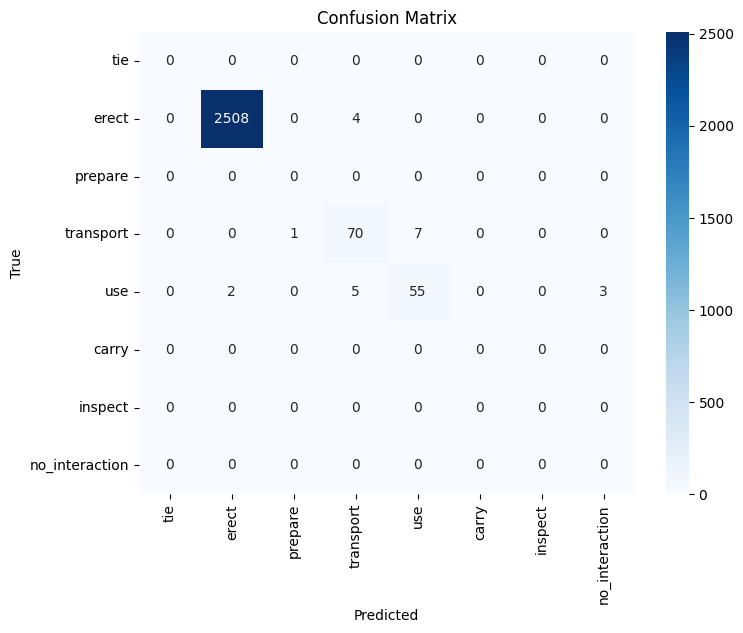

In [19]:
# ticklabels = action_classes
ticklabels = new_action_classes
if 'new_action_classes' in globals() and isinstance(new_action_classes, (list, tuple)): # type: ignore
    y_true = [ticklabels.index(new_action_classes[y]) for y in y_true] # type: ignore
    y_pred = [ticklabels.index(new_action_classes[y]) for y in y_pred] # type: ignore
    
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(ticklabels))))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=vis_new_action_classes, yticklabels=vis_new_action_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [20]:
print(test_features_dirs[0])

/root/vs-gats-plaster/deepsort/hiergat_data_v2601_2s/C0109_full_MP4_anno_for_labelling_full_temporal_2s/features
